### Table of contents
1. [Supp Figure 10A-B. Cox models for PFS in IO+VEGF arm of JAV101 (hallmark IFNG signature, 6p21 disomy or deletion)](#1)
2. [Supp Figure 10C-D. Cox models for PFS in IO+VEGF arm of JAV101 (tumor/fibroblast IFNg signature, 6p21 disomy or deletion)](#2)
3. [Supp Figure 11A-B. Cox models for PFS in IO+VEGF arm of IMM151 and JAV101 (Zemek at al fast on/off signature)](#3)
4. [Supp Figure 11C-D. Logistic regression models for CB vs NCB in IO+VEGF arm of IMM151 and JAV101 (Zemek at al fast on/off signature)](#4)

In [1]:
library(harmony)
library(hacksig)
library(car)
library(corrplot)
library(ComplexHeatmap)
library(rstatix)
library(stringr)
library(Seurat)
library(useful)
library(dplyr)
library(ggpubr)
library(ggrepel)
library(glue)
library(RColorBrewer)
library(ggpubr)
library(ggrepel)
library(reshape2)
library(lmerTest)
library(Scillus)
library(cowplot)
library(viridis)
library(hrbrthemes)
library(ggridges)
library(pheatmap)
library(ggplot2)
library(magrittr)
library(broom)
library(yarrr)

library(survival)
library(survminer)
library(tidyverse)
library(forestmodel)
library(scales)
library(pROC)
library(car)


set.seed(1234)

options(repr.plot.width=12, repr.plot.height=9)

Loading required package: Rcpp

Loading required package: carData

corrplot 0.92 loaded

Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: 'rstatix'


The following object is masked from 'package:stats':

    filter


Attaching SeuratObject

Attaching sp

Loading required package: ggplot2


Attaching package: 'dplyr'


The following object is masked from 'package:car

In [2]:
ISG_sigs = readRDS("../../Signatures/Final_Manuscript_Signatures_CTS_ISGs.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

[1] "IFI30"    "LPAR6"    "FCGR1A"   "MYD88"    "VSIG4"    "LILRB1"  
 [7] "IL10"     "SECTM1"   "MX2"      "CXCL10"   "CD86"     "GCH1"    
[13] "SIGLEC10" "FPR1"     "JAK2"     "CXCL9"    "TNFAIP2"  "PTGS2"   
[19] "IL15"     "LAMP3"    "NFKB1"

[1] "C1R"     "PFKP"    "TNFAIP6" "C1S"     "CFB"     "SSPN"

[1] "NLRC5" "OASL"  "IL2RB" "XCL1"  "GZMA"  "STAT4" "CCL5"  "SOCS1"

### Supp Figure 10A-B. Cox models for PFS in IO+VEGF arm of JAV101 (hallmark IFNG signature, 6p21 disomy or deletion) <a name="1"></a>

### Set panels for forest_model plots

In [3]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Hazard ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### Read in JAV101 data

In [4]:
clin_jav101_full = readRDS("../../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

df = data.frame(table(colnames(clin_jav101_full)))
subset(df, Freq > 1)

clin_jav101_full = subset(clin_jav101_full, select = -c(CD8A,Eosinophils,IFIT3, Neutrophils) )

,Var1,Freq
,<fct>,<int>
14682,CD8A,2
17979,Eosinophils,2
21236,IFIT3,2
27495,Neutrophils,2


In [5]:
cn = scan("../../Trial_Cohorts/JAV101/Javelin_6p21_loss_GISTIC.txt", what = "character")
corner(cn)
length(cn)

[1] "10011001_6203185783_T" "10011004_6204067375_T" "10011006_6204067377_T"
[4] "10011008_6204067223_T" "10011017_6204067222_T"

[1] 141

In [6]:
corner(clin_jav101_full$ID)

[1] "10011001_6203185783" "10011004_6204067375" "10011006_6204067377"
[4] "10011007_6204067220" "10011008_6204067223"

In [7]:
cn = str_replace_all(cn, pattern = "_T","")
corner(cn)
length(cn)

length(intersect(cn, clin_jav101_full$ID))

[1] "10011001_6203185783" "10011004_6204067375" "10011006_6204067377"
[4] "10011008_6204067223" "10011017_6204067222"

[1] 141

[1] 137

In [8]:
clin_jav101_full = mutate(clin_jav101_full, GISTIC_6p21_loss = ifelse(ID %in% cn, "Deletion","Disomy"))
table(clin_jav101_full$GISTIC_6p21_loss)


Deletion   Disomy 
     137      591 

### 6p21 disomy


 CB NCB 
194  75 


Call:
glm(formula = Benefit_Binary_Num ~ scale(HALLMARK_INTERFERON_GAMMA_RESPONSE) + 
    scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", 
    data = Disomy)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2283  -1.2250   0.6820   0.7986   1.2524  

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -0.33095    0.49517  -0.668  0.50390
scale(HALLMARK_INTERFERON_GAMMA_RESPONSE)  0.02333    0.14838   0.157  0.87509
scale(Age)                                 0.26173    0.13962   1.875  0.06085
SexM                                       0.01515    0.32727   0.046  0.96308
MSKCCINTERMEDIATE                          0.85301    0.42776   1.994  0.04614
MSKCCFAVORABLE                             1.62019    0.51990   3.116  0.00183
PDL1_status_v1Y                            0.48912    0.32744   1.494  0.13524
                                            
(Intercept)        

,GVIF,Df,GVIF^(1/(2*Df))
scale(HALLMARK_INTERFERON_GAMMA_RESPONSE),1.144082,1,1.069618
scale(Age),1.008348,1,1.004165
Sex,1.034287,1,1.016999
MSKCC,1.043576,2,1.010720
PDL1_status_v1,1.176124,1,1.084493


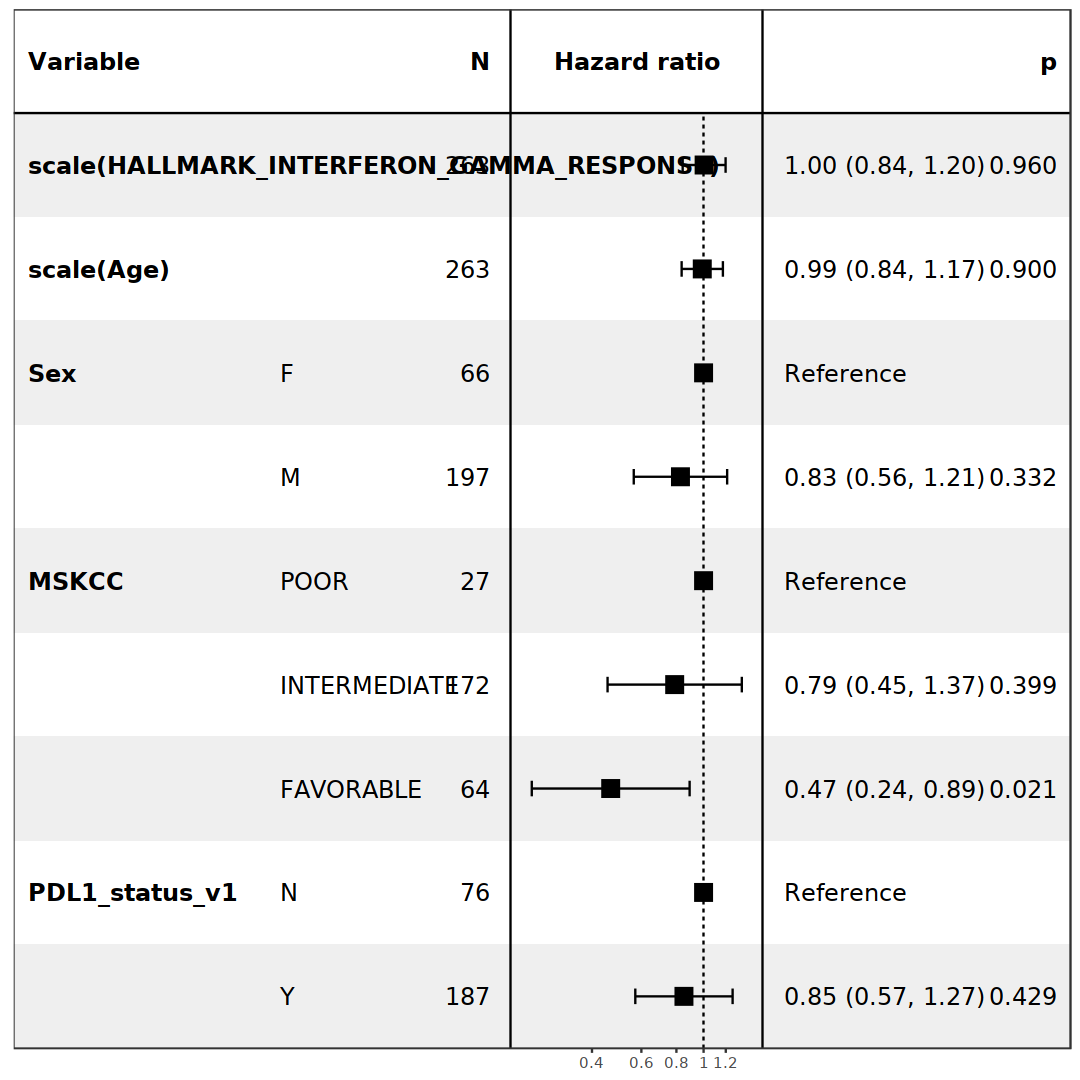

In [9]:
options(repr.plot.width=9, repr.plot.height=9)

Disomy = subset(clin_jav101_full, GISTIC_6p21_loss == "Disomy" & Arm == "Avelumab + Axitinib")

Disomy = subset(Disomy, ORR %in% c("CR","PD","PR","SD"))
Disomy = mutate(Disomy, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(Disomy$Benefit)

Disomy = mutate(Disomy, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(HALLMARK_INTERFERON_GAMMA_RESPONSE) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = Disomy)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ scale(HALLMARK_INTERFERON_GAMMA_RESPONSE) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = Disomy)
Disomy_plot = forest_model(res.cox,panels,recalculate_width = F)
Disomy_plot

### 6p21 deletion


 CB NCB 
 45  21 


Call:
glm(formula = Benefit_Binary_Num ~ scale(HALLMARK_INTERFERON_GAMMA_RESPONSE) + 
    scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", 
    data = Deletion)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9911  -0.8997   0.4586   0.7344   2.4594  

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -2.92230    1.26748  -2.306   0.0211
scale(HALLMARK_INTERFERON_GAMMA_RESPONSE)  0.54912    0.33873   1.621   0.1050
scale(Age)                                -0.05273    0.31593  -0.167   0.8675
SexM                                       0.83670    0.68719   1.218   0.2234
MSKCCINTERMEDIATE                          2.49560    1.05950   2.355   0.0185
MSKCCFAVORABLE                             3.57192    1.36344   2.620   0.0088
PDL1_status_v1Y                            1.26169    0.66470   1.898   0.0577
                                            
(Intercept)      

,GVIF,Df,GVIF^(1/(2*Df))
scale(HALLMARK_INTERFERON_GAMMA_RESPONSE),1.164110,1,1.078939
scale(Age),1.106132,1,1.051728
Sex,1.110688,1,1.053892
MSKCC,1.268361,2,1.061233
PDL1_status_v1,1.164200,1,1.078981


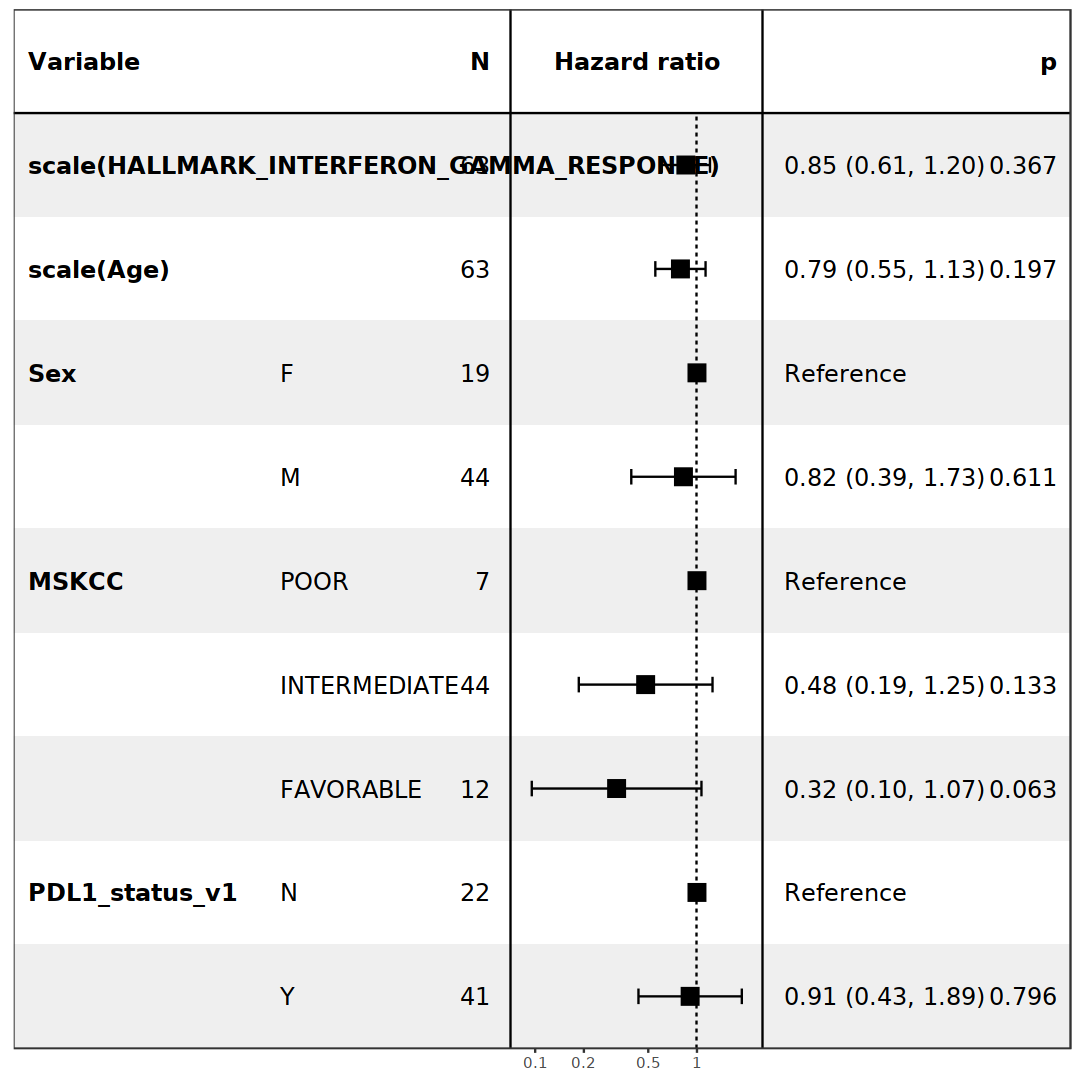

In [10]:
options(repr.plot.width=9, repr.plot.height=9)

Deletion = subset(clin_jav101_full, GISTIC_6p21_loss == "Deletion" & Arm == "Avelumab + Axitinib")

Deletion = subset(Deletion, ORR %in% c("CR","PD","PR","SD"))
Deletion = mutate(Deletion, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(Deletion$Benefit)

Deletion = mutate(Deletion, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(HALLMARK_INTERFERON_GAMMA_RESPONSE) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = Deletion)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ scale(HALLMARK_INTERFERON_GAMMA_RESPONSE) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = Deletion)
Deletion_plot = forest_model(res.cox,panels,recalculate_width = F)
Deletion_plot

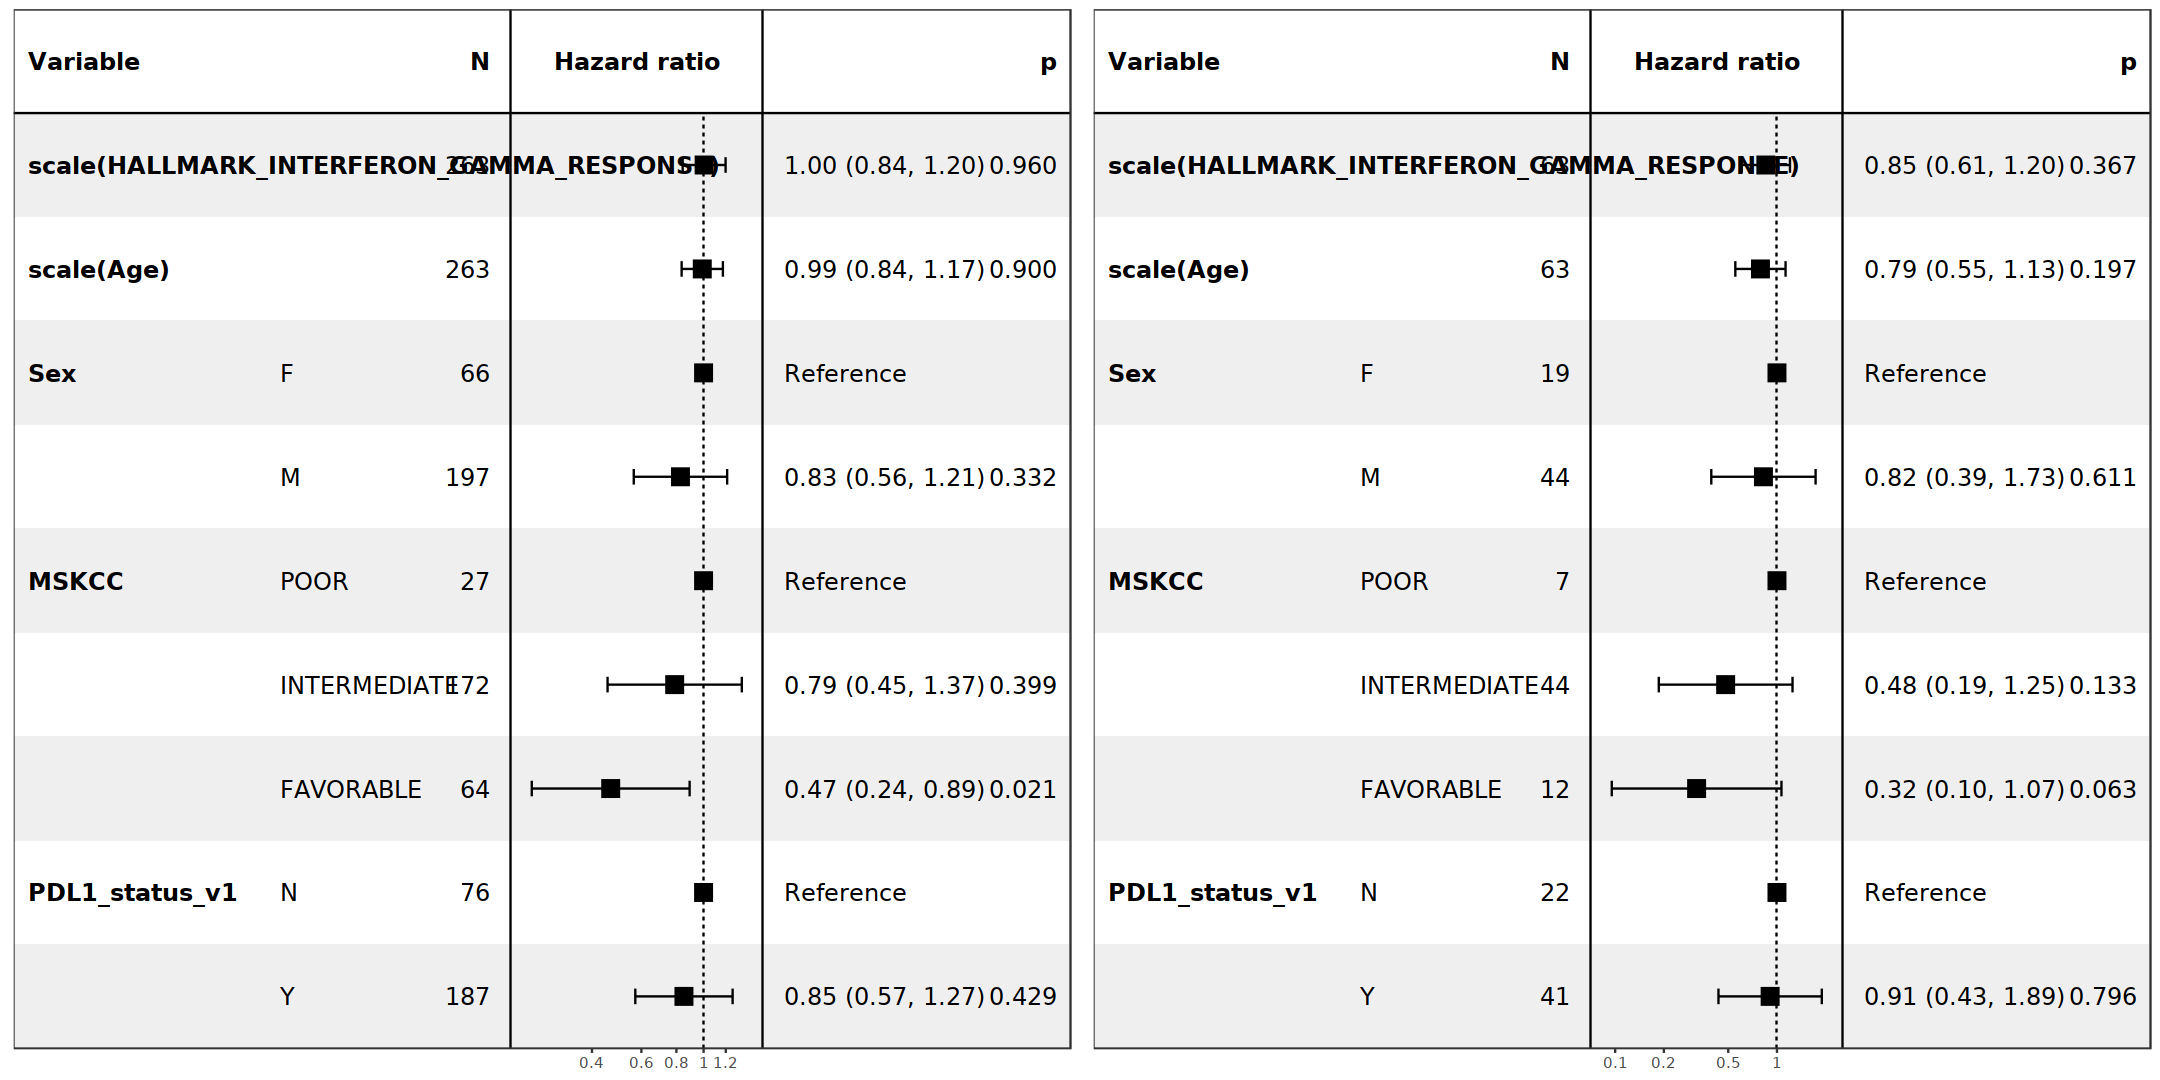

In [11]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(Disomy_plot, Deletion_plot)

ggsave("../../Supp_Figures/Supp_Figure10_11/Supp_Figure10A_B_Cox_Jav101_HallmarkIFNG_6p21_ICB_Scaled.pdf",width = 18, height = 9)

### Supp Figure 10C-D. Cox models for PFS in IO+VEGF arm of JAV101 (tumor/fibroblast IFNg signature, 6p21 disomy or deletion) <a name="2"></a>

### 6p21 disomy


 CB NCB 
194  75 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_tumor) + 
    scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + 
    MSKCC + PDL1_status_v1, family = "binomial", data = Disomy)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1093  -1.1454   0.6613   0.8274   1.4044  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                  -0.30830    0.50301  -0.613  0.53994   
scale(manuscript_IFNG_tumor)  0.09354    0.15557   0.601  0.54765   
scale(Tumor_CS)              -0.25367    0.15862  -1.599  0.10976   
scale(Fibroblast_CS)         -0.27259    0.15032  -1.813  0.06977 . 
scale(Age)                    0.23955    0.14006   1.710  0.08721 . 
SexM                         -0.01525    0.33280  -0.046  0.96346   
MSKCCINTERMEDIATE             0.89819    0.43972   2.043  0.04109 * 
MSKCCFAVORABLE                1.65507    0.52897   3.129  0.00176 **
PDL1_status_v1Y               0.45944    0.3250

,GVIF,Df,GVIF^(1/(2*Df))
scale(manuscript_IFNG_tumor),1.142471,1,1.068864
scale(Tumor_CS),1.263248,1,1.123943
scale(Fibroblast_CS),1.258570,1,1.121860
scale(Age),1.011997,1,1.005981
Sex,1.037353,1,1.018505
MSKCC,1.074497,2,1.018125
PDL1_status_v1,1.134262,1,1.065017


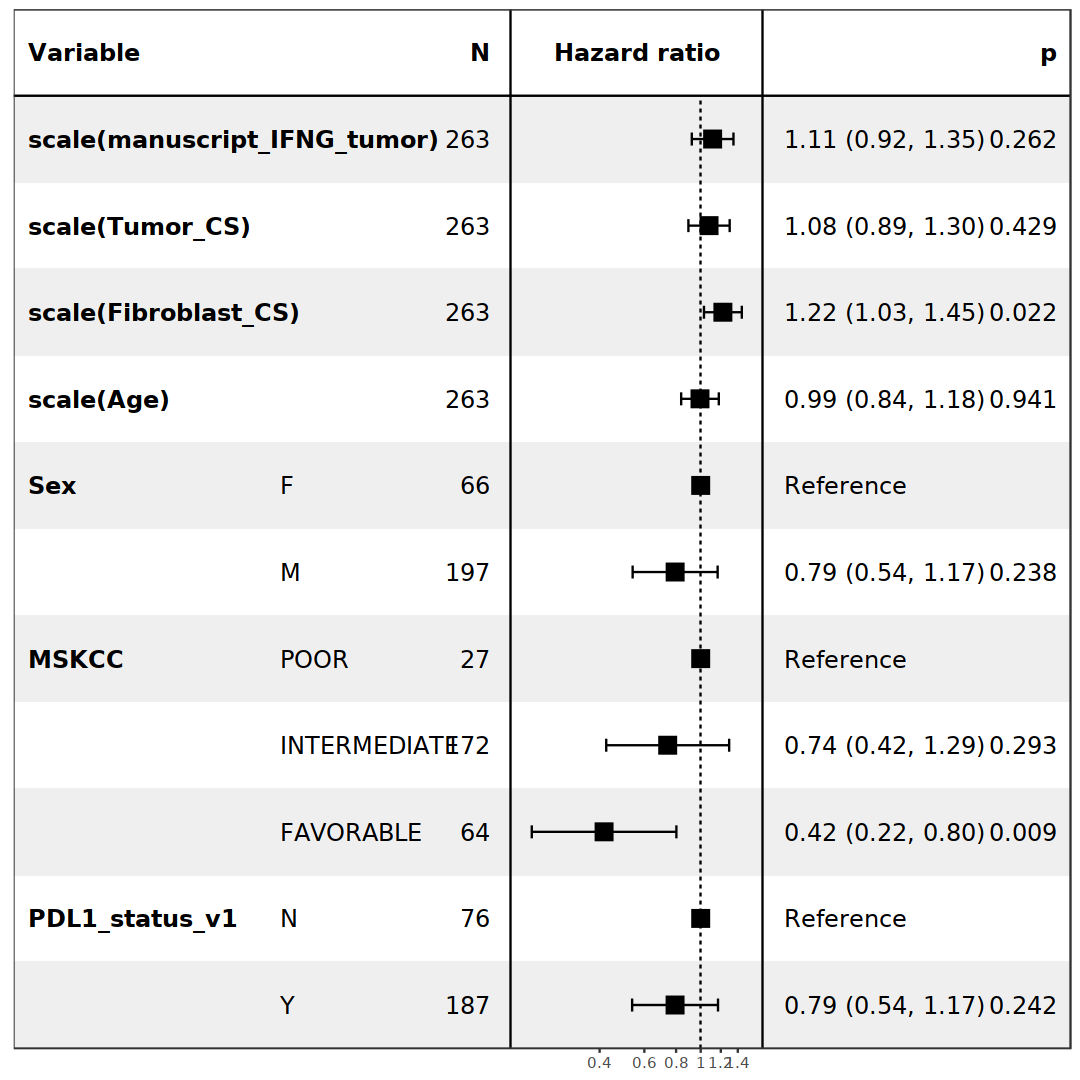

In [12]:
options(repr.plot.width=9, repr.plot.height=9)

Disomy = subset(clin_jav101_full, GISTIC_6p21_loss == "Disomy" & Arm == "Avelumab + Axitinib")

Disomy = subset(Disomy, ORR %in% c("CR","PD","PR","SD"))
Disomy = mutate(Disomy, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(Disomy$Benefit)

Disomy = mutate(Disomy, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = Disomy)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = Disomy)
Disomy_plot = forest_model(res.cox,panels,recalculate_width = F)
Disomy_plot

### 6p21 deletion


 CB NCB 
 45  21 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_tumor) + 
    scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + 
    MSKCC + PDL1_status_v1, family = "binomial", data = Deletion)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0478  -0.5250   0.3882   0.6361   1.7448  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                   -3.3685     1.3162  -2.559  0.01049 * 
scale(manuscript_IFNG_tumor)  -0.5307     0.3951  -1.343  0.17914   
scale(Tumor_CS)               -0.3823     0.3534  -1.082  0.27930   
scale(Fibroblast_CS)          -1.2628     0.4893  -2.580  0.00987 **
scale(Age)                    -0.4836     0.3868  -1.250  0.21113   
SexM                           0.9974     0.7504   1.329  0.18380   
MSKCCINTERMEDIATE              2.7708     1.0886   2.545  0.01092 * 
MSKCCFAVORABLE                 4.7098     1.6316   2.887  0.00389 **
PDL1_status_v1Y                1.3216     0.7

,GVIF,Df,GVIF^(1/(2*Df))
scale(manuscript_IFNG_tumor),1.129847,1,1.062943
scale(Tumor_CS),1.109727,1,1.053436
scale(Fibroblast_CS),1.283933,1,1.133107
scale(Age),1.331912,1,1.154085
Sex,1.103479,1,1.050466
MSKCC,1.449921,2,1.097327
PDL1_status_v1,1.223655,1,1.106189


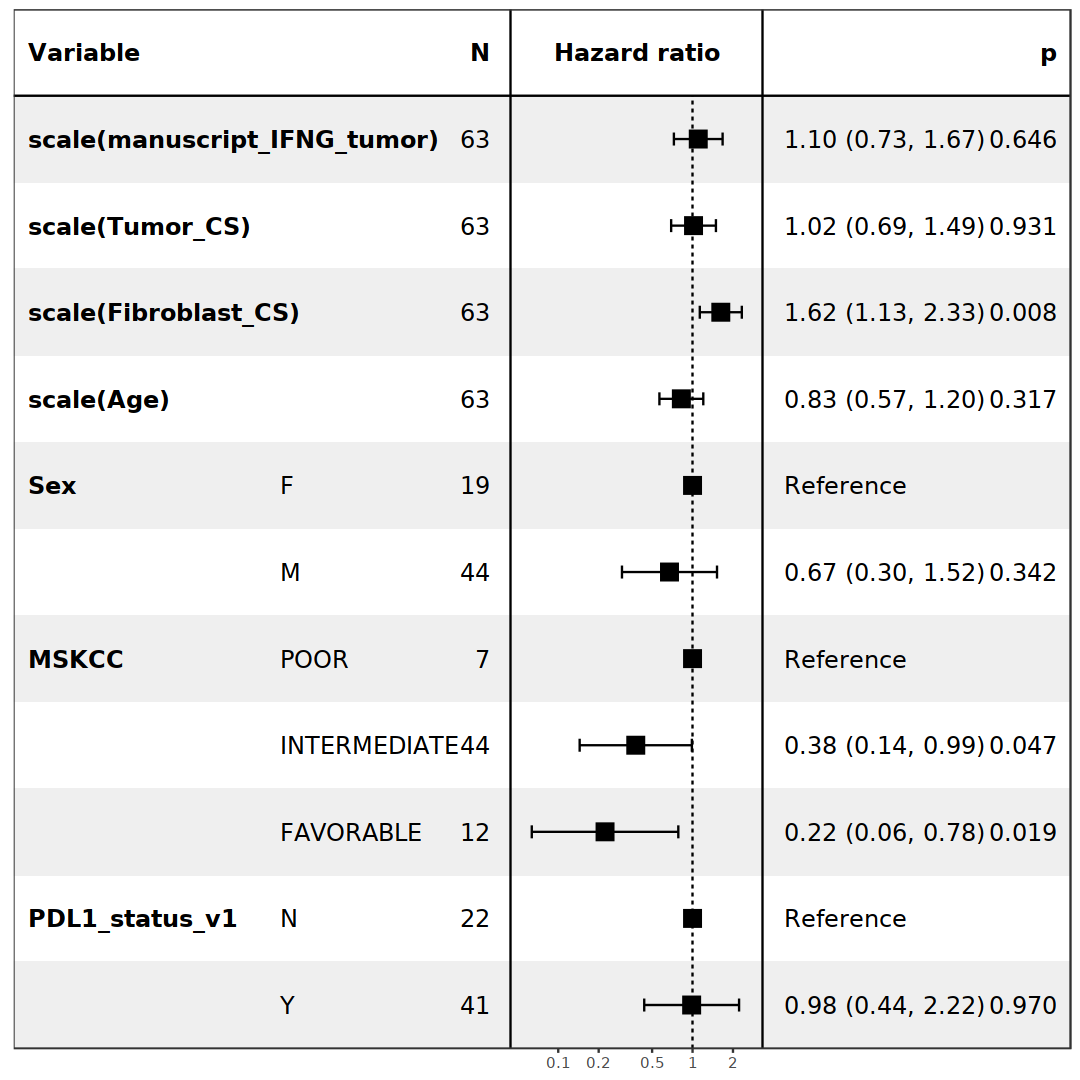

In [13]:
options(repr.plot.width=9, repr.plot.height=9)

Deletion = subset(clin_jav101_full, GISTIC_6p21_loss == "Deletion" & Arm == "Avelumab + Axitinib")

Deletion = subset(Deletion, ORR %in% c("CR","PD","PR","SD"))
Deletion = mutate(Deletion, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(Deletion$Benefit)

Deletion = mutate(Deletion, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = Deletion)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = Deletion)
Deletion_plot = forest_model(res.cox,panels,recalculate_width = F)
Deletion_plot

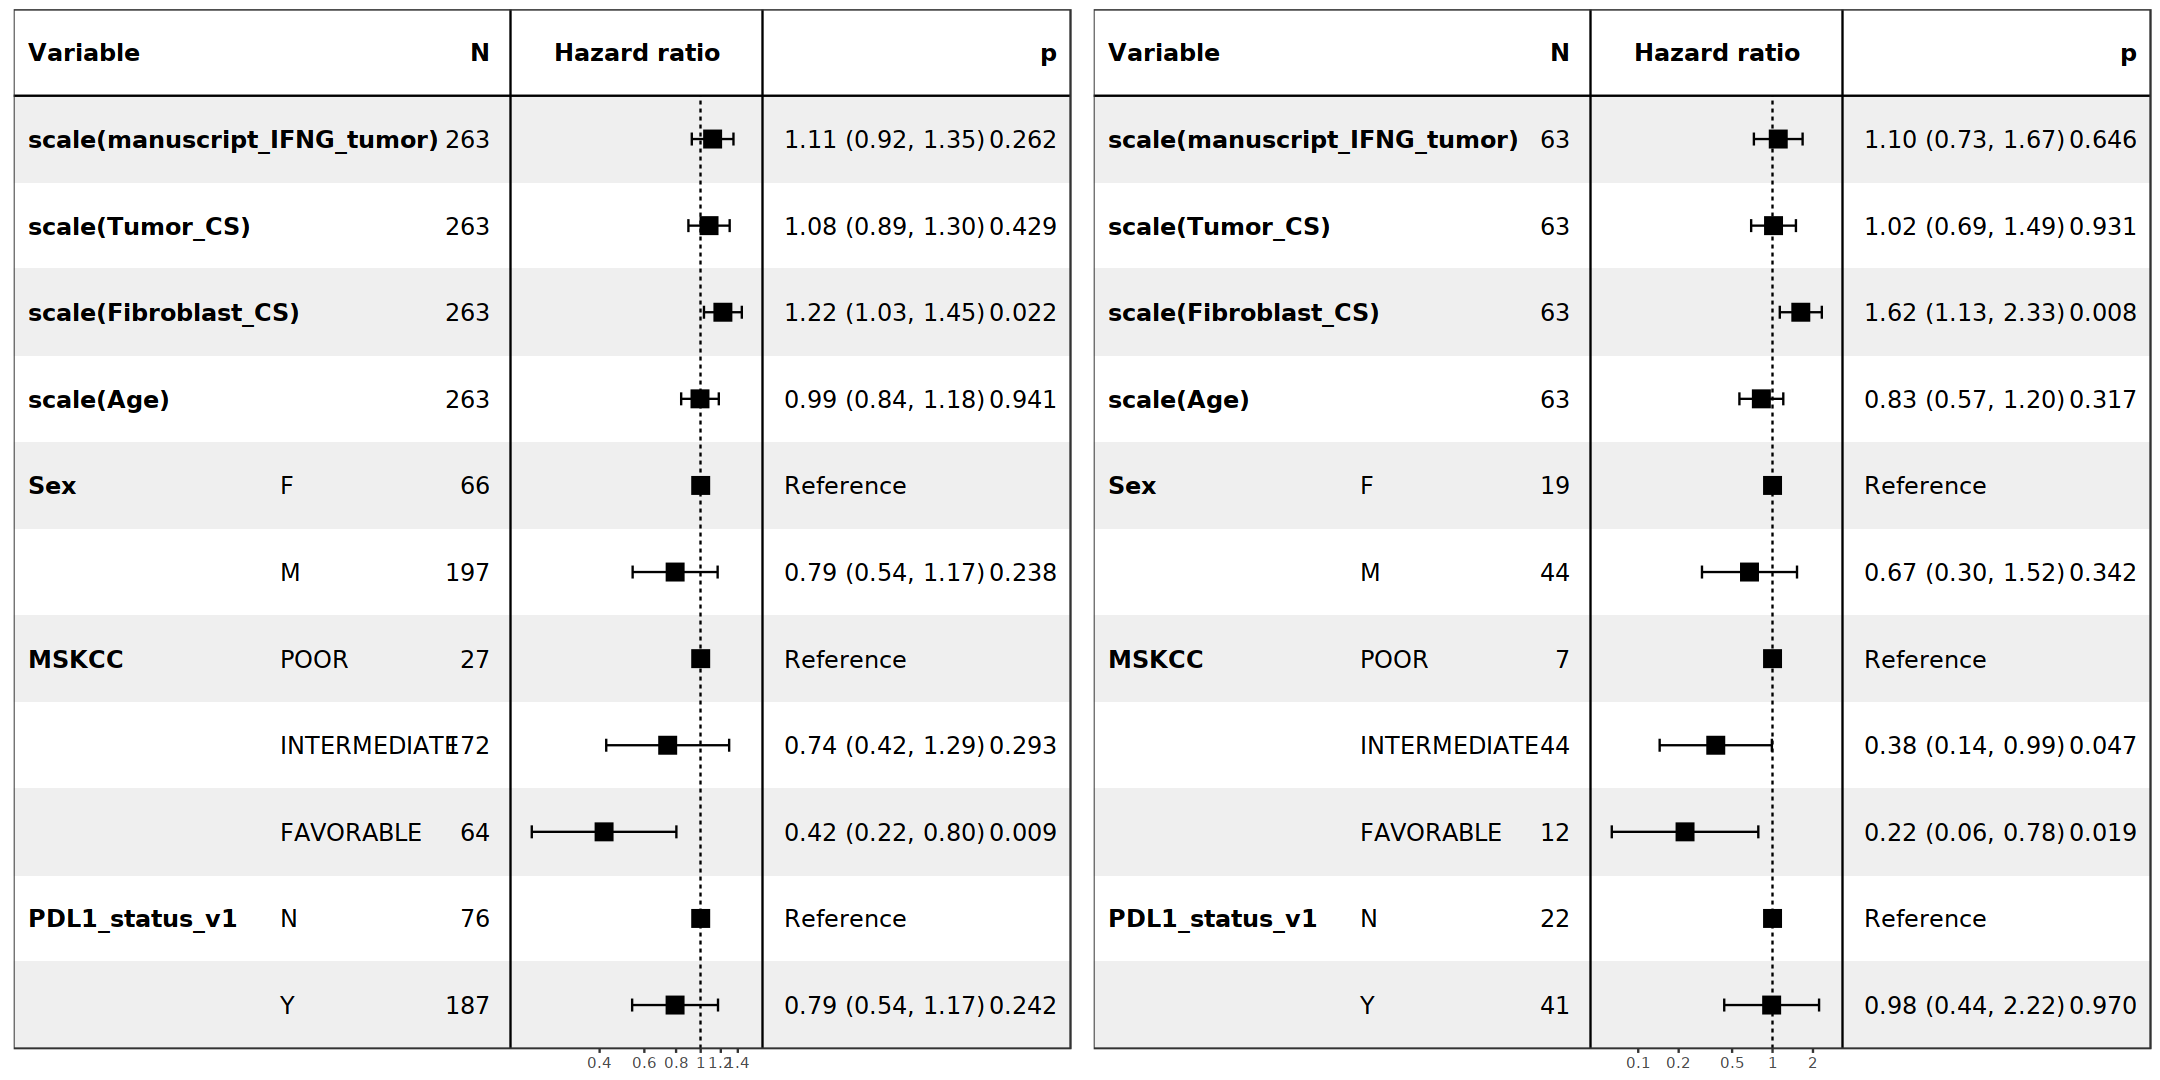

In [14]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(Disomy_plot, Deletion_plot)

ggsave("../../Supp_Figures/Supp_Figure10_11/Supp_Figure10C_D_Cox_Jav101_TumorFibIFNG_6p21_ICB_Scaled.pdf",width = 18, height = 9)

### Supp Figure 11A-B. Cox models for PFS in IO+VEGF arm of IMM151 and JAV101 (Zemek at al fast on/off signature) <a name="3"></a>

### Score IMM151 for Zemek et al fast on/fast off IFNb signature

In [15]:
zemek = scan("../../Signatures//FastOnOff_Zemek.txt",what = "character", sep = '\t')
zemek

[1] "ADAR"    "APOL6"   "B2M"     "BATF2"   "BST2"    "C1R"     "C1S"    
  [8] "CARD16"  "CASP1"   "CASP7"   "CCL2"    "CCL7"    "CD274"   "CD40"   
 [15] "CDKN1A"  "CFB"     "CXCL10"  "CXCL11"  "CXCL9"   "DDX58"   "DDX60"  
 [22] "DHX58"   "EIF2AK2" "FAS"     "FCGR1B"  "FCGR1A"  "GBP6"    "GBP2"   
 [29] "GCH1"    "GZMA"    "HERC6"   "IDO1"    "IFI35"   "IFI44"   "IFI44L" 
 [36] "IFIH1"   "IFIT2"   "IFIT3"   "IFITM3"  "IFITM2"  "IFITM1"  "IL15"   
 [43] "IRF1"    "IRF7"    "IRF9"    "ISG15"   "ISG20"   "LAP3"    "LY6E"   
 [50] "LYSMD2"  "MOV10"   "MVP"     "MX1"     "MYD88"   "NAMPT"   "NLRC5"  
 [57] "NMI"     "NUB1"    "OAS1"    "OAS2"    "OAS3"    "OASL"    "OGFR"   
 [64] "PARP12"  "PARP14"  "PARP9"   "PFKP"    "PIM1"    "PLA2G4A" "PLSCR1" 
 [71] "PML"     "PNP"     "PSMA2"   "PSMA3"   "PSMB10"  "PSMB2"   "PSMB8"  
 [78] "PSMB9"   "PSME1"   "PSME2"   "RIPK1"   "RIPK2"   "RNF31"   "RSAD2"  
 [85] "RTP4"    "SAMD9L"  "SAMHD1"  "SECTM1"  "SOCS1"   "SOD2"    "SPPL2A" 
 [92] "ST3GAL5" "STAT1"   "STAT2"   "TAP1"    "TAPBP"   "TMEM140" "TRIM5"  
 [99] "TRIM21"  "UBA7"    "UBE2L6"  "UPP1"    "USP18"   "WARS1"   "XAF1"   
[106] "ZBP1"    "ZNFX1"

In [16]:
ISG_sigs$Zemek_2022_FastOnOff = zemek

In [17]:
clin_imm151_full = readRDS("../../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

df = data.frame(table(colnames(clin_imm151_full)))
subset(df, Freq > 1)

clin_imm151_full = subset(clin_imm151_full, select = -c(IFIT3) )

,Var1,Freq
,<fct>,<int>
8604,IFIT3,2


In [18]:
imm151_rna = readRDS("../../Trial_Cohorts/IMM151/IMM151_RNASeq_TPM.RDS")
imm151_clin = readRDS("../../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata.RDS")

dim(imm151_rna)
dim(imm151_clin)

[1] 25297   823

[1] 823  92

In [19]:
options(future.globals.maxSize= 50000*1024^2)

imm151_gs = hack_sig(
  imm151_rna,
  signatures = ISG_sigs,
  method = "zscore")

In [20]:
imm151_gs_final = data.frame(imm151_gs[,2:ncol(imm151_gs)])
row.names(imm151_gs_final) = imm151_gs$sample_id

corner(imm151_gs_final)

setequal(row.names(imm151_gs_final),row.names(clin_imm151_full))

,manuscript_IFN1_myeloid,manuscript_IFN1_t_nk,manuscript_IFN1_tumor,manuscript_IFNG_myeloid,manuscript_IFNG_t_nk
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EA-37ce247b1d,-5.0547058,-3.5229063,-0.5651403,-5.9945075,-3.6849959
EA-c98e425b64,0.2675114,1.9489467,0.7658367,2.4105922,2.2322537
EA-bb52459cfb,3.6933034,1.4646782,1.9194814,3.0021903,2.0395606
EA-7e3f099861,0.9905708,1.7376840,0.6346561,2.5378846,1.5752130
EA-080ae948aa,0.7664715,-0.7538771,0.2212405,0.3692715,-0.3709755


[1] TRUE

In [21]:
clin_imm151_full$Zemek_2022_FastOnOff = imm151_gs_final$Zemek_2022_FastOnOff


 CB NCB 
263 117 


Call:
glm(formula = Benefit_Binary_Num ~ scale(Zemek_2022_FastOnOff) + 
    scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", 
    data = atezo_bev)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0909  -1.3749   0.7916   0.9050   1.2391  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                   0.30075    0.36679   0.820  0.41223   
scale(Zemek_2022_FastOnOff)   0.01526    0.12034   0.127  0.89912   
scale(AGE)                    0.17882    0.11501   1.555  0.12001   
SEXM                          0.13616    0.24341   0.559  0.57589   
MSKCC_RISK_SCOREIntermediate  0.16829    0.34650   0.486  0.62718   
MSKCC_RISK_SCORELow           1.20261    0.46128   2.607  0.00913 **
PDL1_IHCPDL1+                 0.27259    0.24265   1.123  0.26128   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 469.2

,GVIF,Df,GVIF^(1/(2*Df))
scale(Zemek_2022_FastOnOff),1.141175,1,1.068258
scale(AGE),1.053955,1,1.026623
SEX,1.013441,1,1.006698
MSKCC_RISK_SCORE,1.016715,2,1.004153
PDL1_IHC,1.110291,1,1.053703


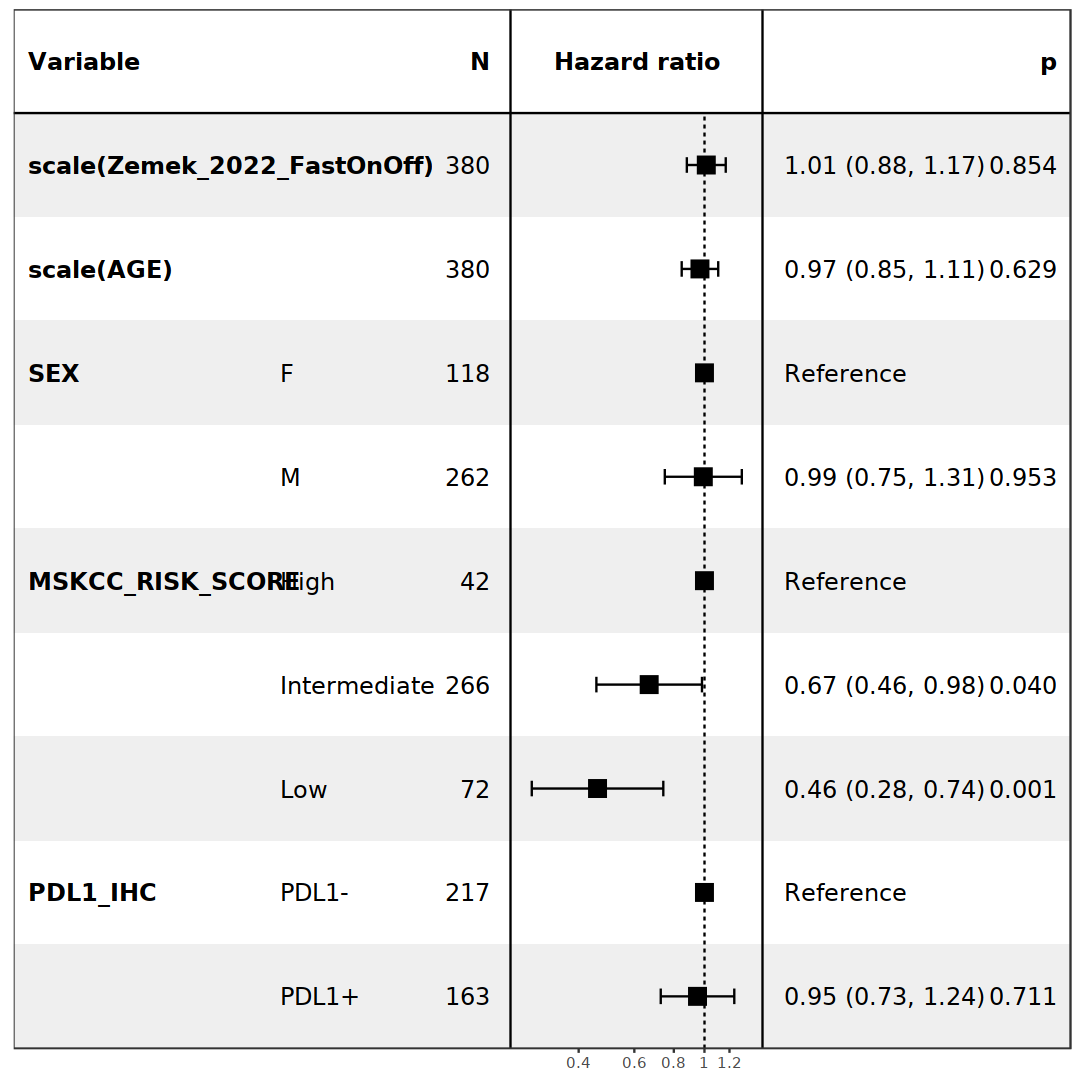

In [22]:
options(repr.plot.width=9, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(Zemek_2022_FastOnOff) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = atezo_bev)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(Zemek_2022_FastOnOff) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev)
imm151_cox_plot = forest_model(res.cox, panels,recalculate_width = F)
imm151_cox_plot

### Score JAV101 for Zemek et al fast on/fast off IFNb signature

In [23]:
clin_jav101_full = readRDS("../../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

df = data.frame(table(colnames(clin_jav101_full)))
subset(df, Freq > 1)

clin_jav101_full = subset(clin_jav101_full, select = -c(CD8A,Eosinophils,IFIT3, Neutrophils) )


,Var1,Freq
,<fct>,<int>
14682,CD8A,2
17979,Eosinophils,2
21236,IFIT3,2
27495,Neutrophils,2


In [24]:
jav101_rna = readRDS("../../Trial_Cohorts/JAV101/JAV101_RNASeq_TPM_log2.RDS")
jav101_clin = readRDS("../../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata.RDS")

dim(jav101_rna)
dim(jav101_clin)

[1] 40032   728

[1] 728  69

In [25]:
options(future.globals.maxSize= 50000*1024^2)

jav101_gs = hack_sig(
  jav101_rna,
  signatures = ISG_sigs,
  method = "zscore")

In [26]:
jav101_gs_final = data.frame(jav101_gs[,2:ncol(jav101_gs)])
row.names(jav101_gs_final) = jav101_gs$sample_id

corner(jav101_gs_final)

setequal(row.names(jav101_gs_final),row.names(clin_jav101_full))

,manuscript_IFN1_myeloid,manuscript_IFN1_t_nk,manuscript_IFN1_tumor,manuscript_IFNG_myeloid,manuscript_IFNG_t_nk
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10011001_6203185783,-1.7899386,-1.0827914,-0.17562036,-1.6648195,-0.48011561
10011004_6204067375,-0.6490106,-3.5230931,0.52433393,-2.1192466,-3.54282924
10011006_6204067377,-0.1433420,-0.9528208,0.29489663,0.5226403,-0.27285987
10011007_6204067220,1.4421168,0.3263469,-0.04649198,1.9110461,0.26343838
10011008_6204067223,1.4223967,0.5665004,1.37561854,1.1366075,0.09528641


[1] TRUE

In [27]:
clin_jav101_full$Zemek_2022_FastOnOff = jav101_gs_final$Zemek_2022_FastOnOff


 CB NCB 
239  96 


Call:
glm(formula = Benefit_Binary_Num ~ scale(Zemek_2022_FastOnOff) + 
    scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", 
    data = avel_axit)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2468  -1.1734   0.6782   0.8045   1.5469  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -0.69390    0.44422  -1.562 0.118273    
scale(Zemek_2022_FastOnOff)  0.05274    0.13299   0.397 0.691661    
scale(Age)                   0.21502    0.12567   1.711 0.087074 .  
SexM                         0.16201    0.28654   0.565 0.571802    
MSKCCINTERMEDIATE            1.00854    0.38197   2.640 0.008283 ** 
MSKCCFAVORABLE               1.80574    0.46906   3.850 0.000118 ***
PDL1_status_v1Y              0.61347    0.28478   2.154 0.031227 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 395.19  on

,GVIF,Df,GVIF^(1/(2*Df))
scale(Zemek_2022_FastOnOff),1.130487,1,1.063244
scale(Age),1.010811,1,1.005391
Sex,1.024611,1,1.012231
MSKCC,1.034940,2,1.008623
PDL1_status_v1,1.145570,1,1.070313


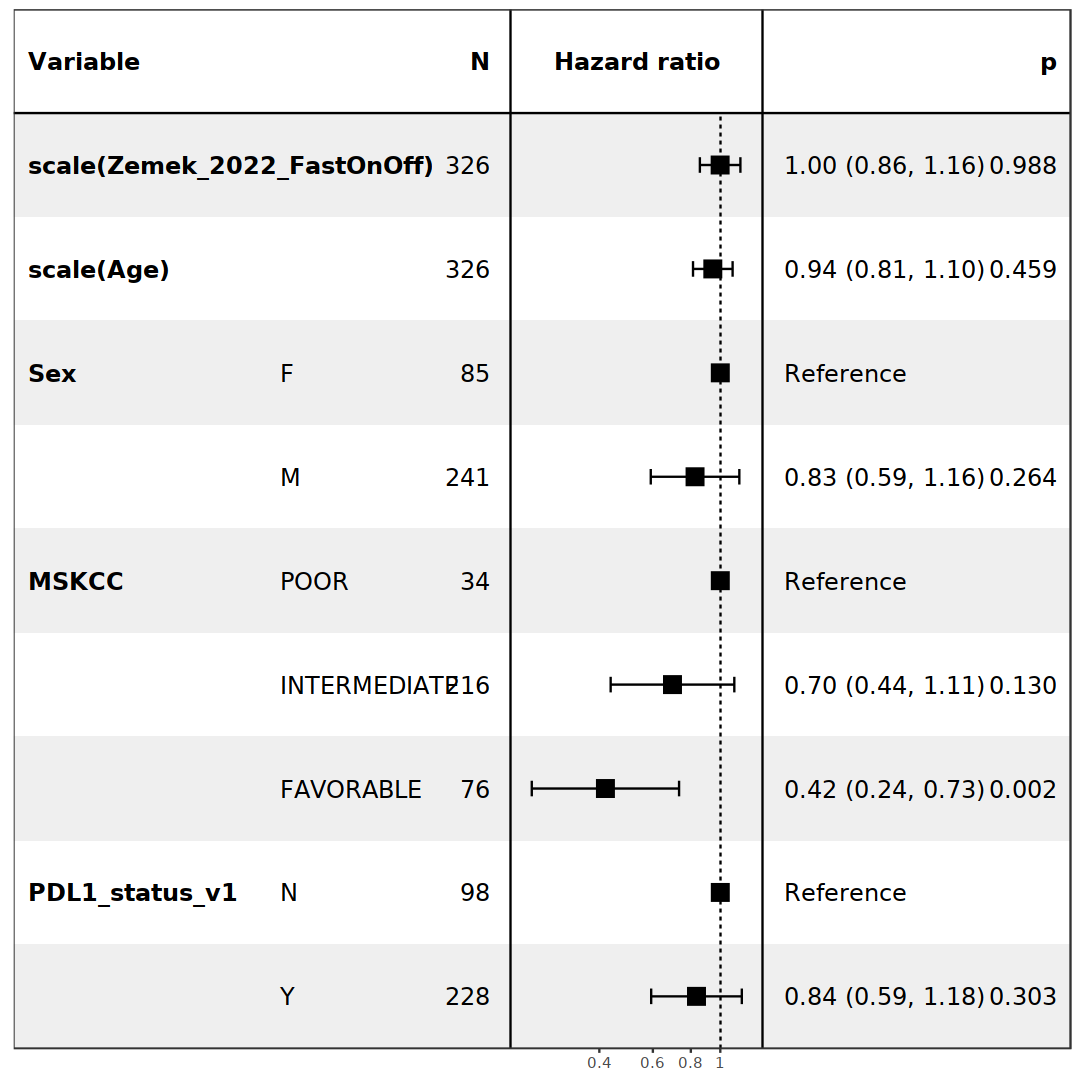

In [28]:
options(repr.plot.width=9, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(Zemek_2022_FastOnOff) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = avel_axit)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ scale(Zemek_2022_FastOnOff) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit)
jav101_cox_plot = forest_model(res.cox,panels,recalculate_width = F)
jav101_cox_plot

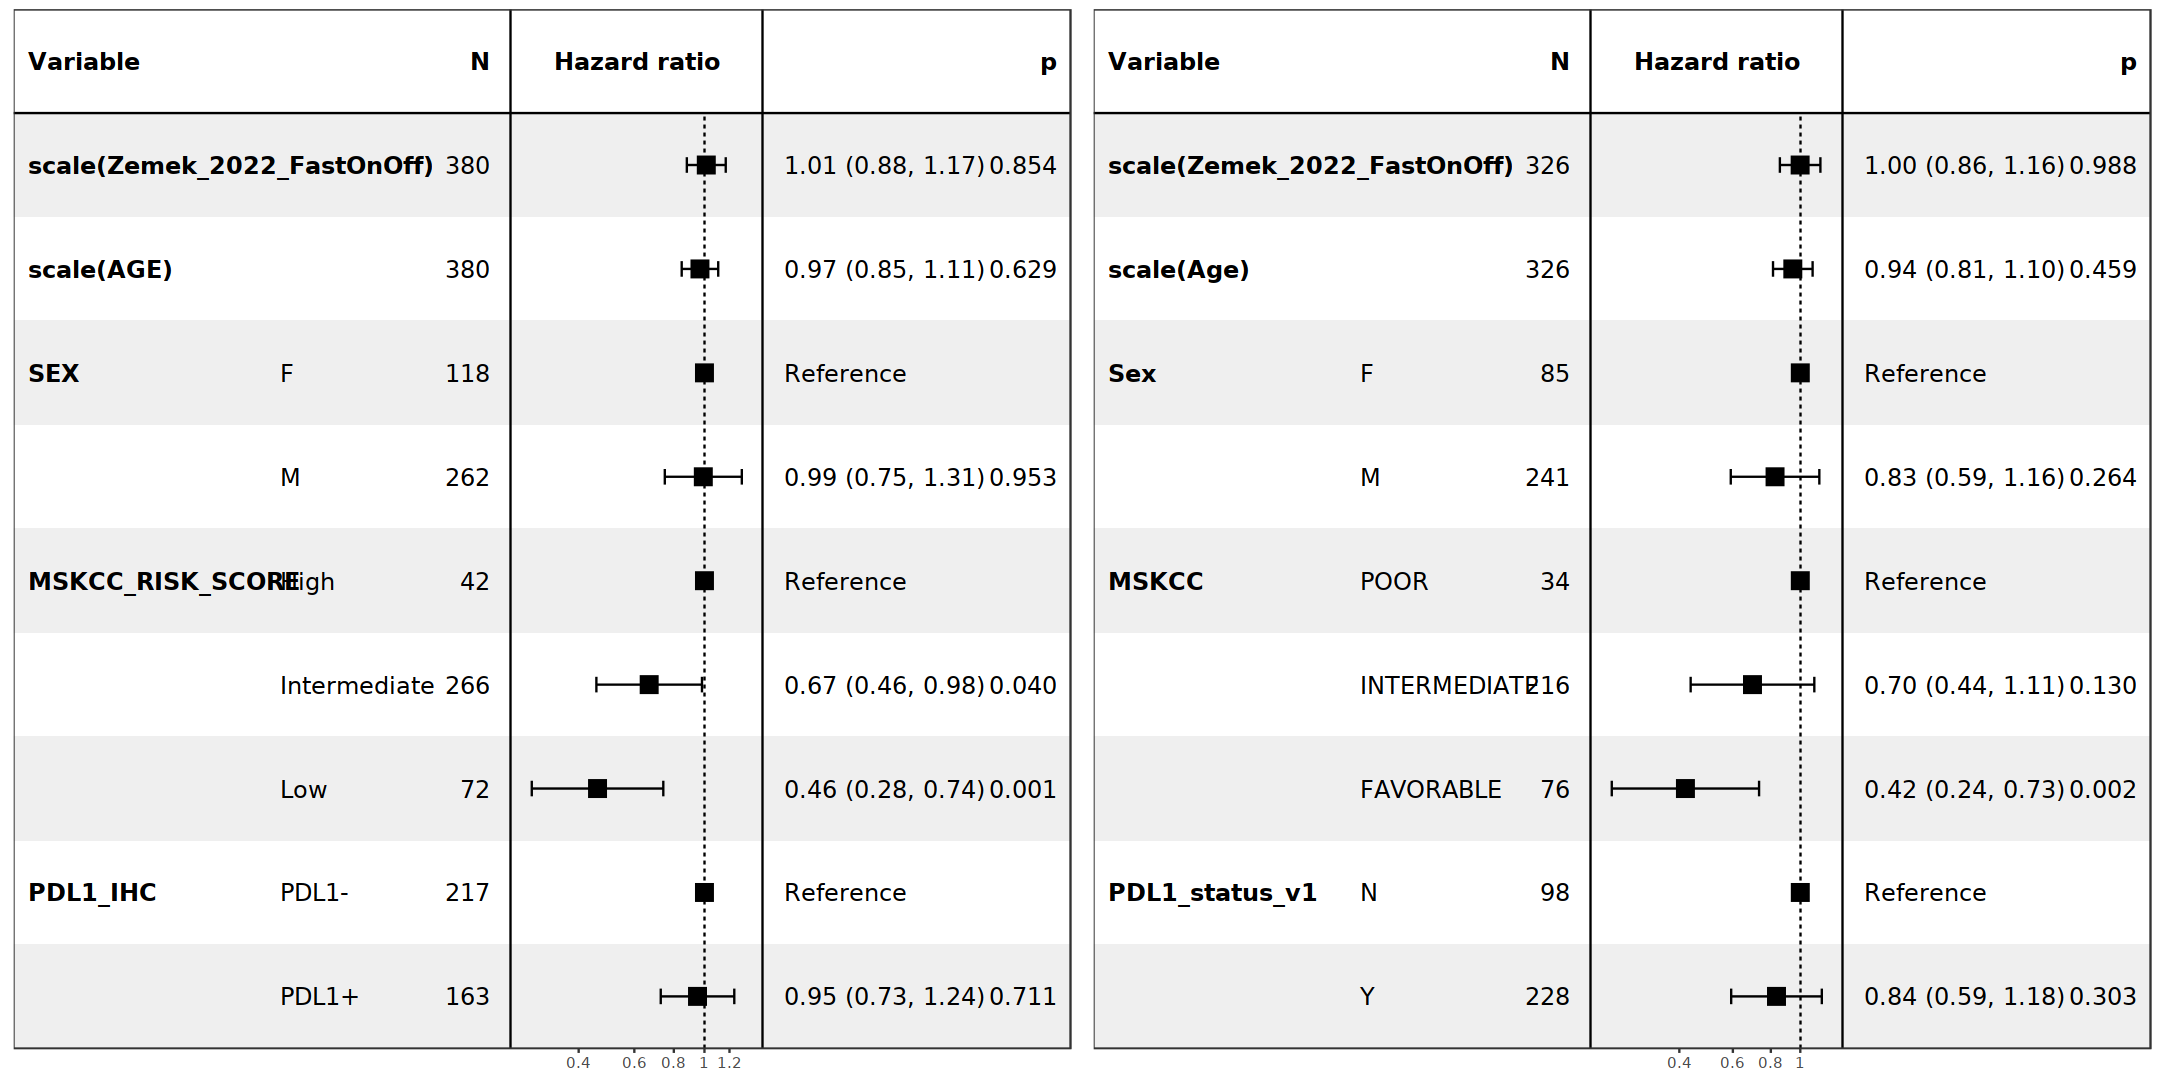

In [29]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(imm151_cox_plot, jav101_cox_plot)

ggsave("../../Supp_Figures/Supp_Figure10_11/Supp_Figure11A_B_Cox_Imm151_Jav101_Zemek_ICB_Scaled.pdf",width = 18, height = 9)

### Supp Figure 11C-D. Logistic regression models for CB vs NCB in IO+VEGF arm of IMM151 and JAV101 (Zemek at al fast on/off signature) <a name="4"></a>

In [30]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.15, item = "forest", hjust = 0.5, heading = "Odds ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)


 CB NCB 
263 117 


Call:
glm(formula = Benefit_Binary_Num ~ scale(Zemek_2022_FastOnOff) + 
    scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", 
    data = atezo_bev)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0909  -1.3749   0.7916   0.9050   1.2391  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)   
(Intercept)                   0.30075    0.36679   0.820  0.41223   
scale(Zemek_2022_FastOnOff)   0.01526    0.12034   0.127  0.89912   
scale(AGE)                    0.17882    0.11501   1.555  0.12001   
SEXM                          0.13616    0.24341   0.559  0.57589   
MSKCC_RISK_SCOREIntermediate  0.16829    0.34650   0.486  0.62718   
MSKCC_RISK_SCORELow           1.20261    0.46128   2.607  0.00913 **
PDL1_IHCPDL1+                 0.27259    0.24265   1.123  0.26128   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 469.2

,GVIF,Df,GVIF^(1/(2*Df))
scale(Zemek_2022_FastOnOff),1.141175,1,1.068258
scale(AGE),1.053955,1,1.026623
SEX,1.013441,1,1.006698
MSKCC_RISK_SCORE,1.016715,2,1.004153
PDL1_IHC,1.110291,1,1.053703


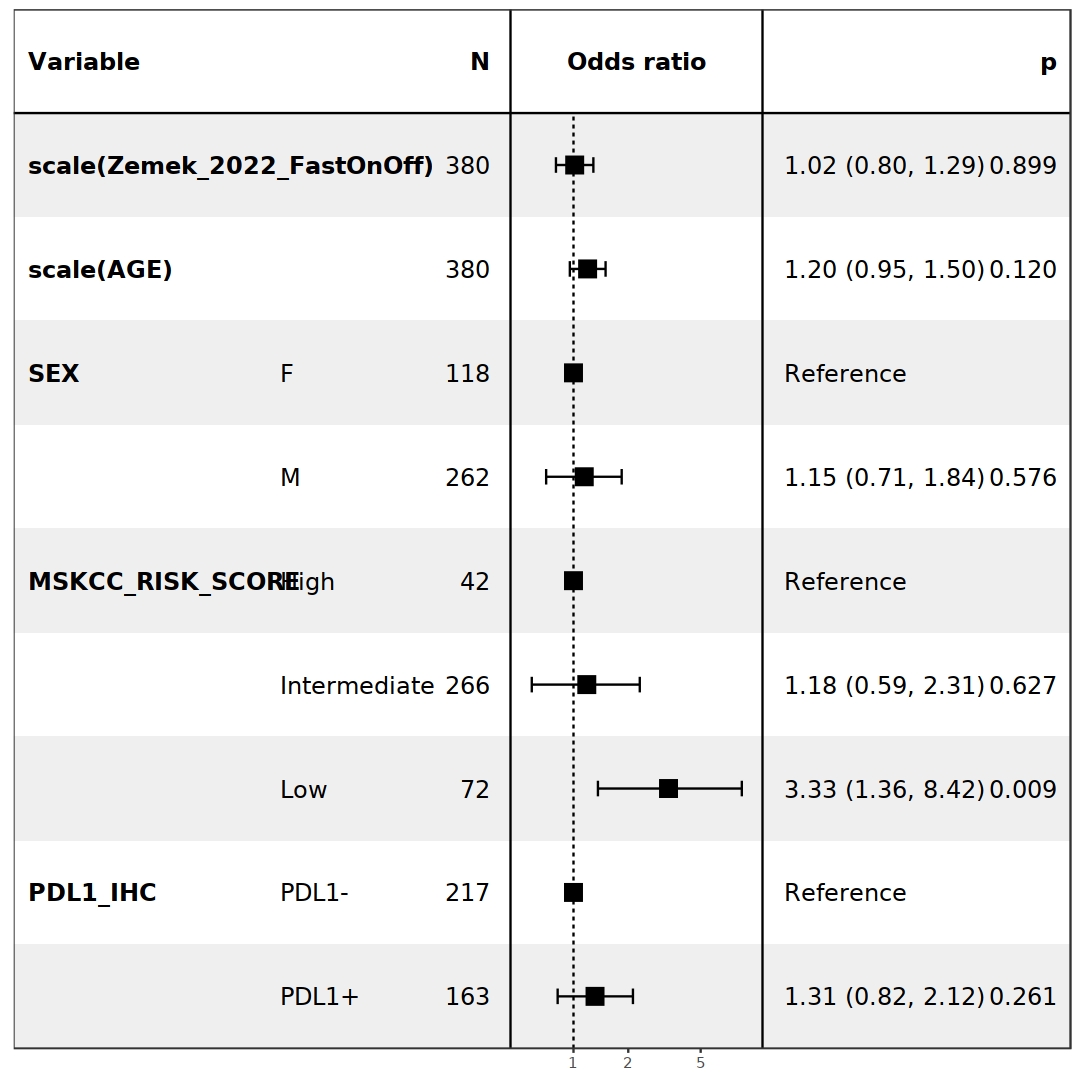

In [31]:
options(repr.plot.width=9, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(Zemek_2022_FastOnOff) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = atezo_bev)
summary(mylogit)
vif(mylogit)

imm151_lr_plot = forest_model(mylogit, panels,recalculate_width = F)
imm151_lr_plot


 CB NCB 
239  96 


Call:
glm(formula = Benefit_Binary_Num ~ scale(Zemek_2022_FastOnOff) + 
    scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", 
    data = avel_axit)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2468  -1.1734   0.6782   0.8045   1.5469  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -0.69390    0.44422  -1.562 0.118273    
scale(Zemek_2022_FastOnOff)  0.05274    0.13299   0.397 0.691661    
scale(Age)                   0.21502    0.12567   1.711 0.087074 .  
SexM                         0.16201    0.28654   0.565 0.571802    
MSKCCINTERMEDIATE            1.00854    0.38197   2.640 0.008283 ** 
MSKCCFAVORABLE               1.80574    0.46906   3.850 0.000118 ***
PDL1_status_v1Y              0.61347    0.28478   2.154 0.031227 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 395.19  on

,GVIF,Df,GVIF^(1/(2*Df))
scale(Zemek_2022_FastOnOff),1.130487,1,1.063244
scale(Age),1.010811,1,1.005391
Sex,1.024611,1,1.012231
MSKCC,1.034940,2,1.008623
PDL1_status_v1,1.145570,1,1.070313


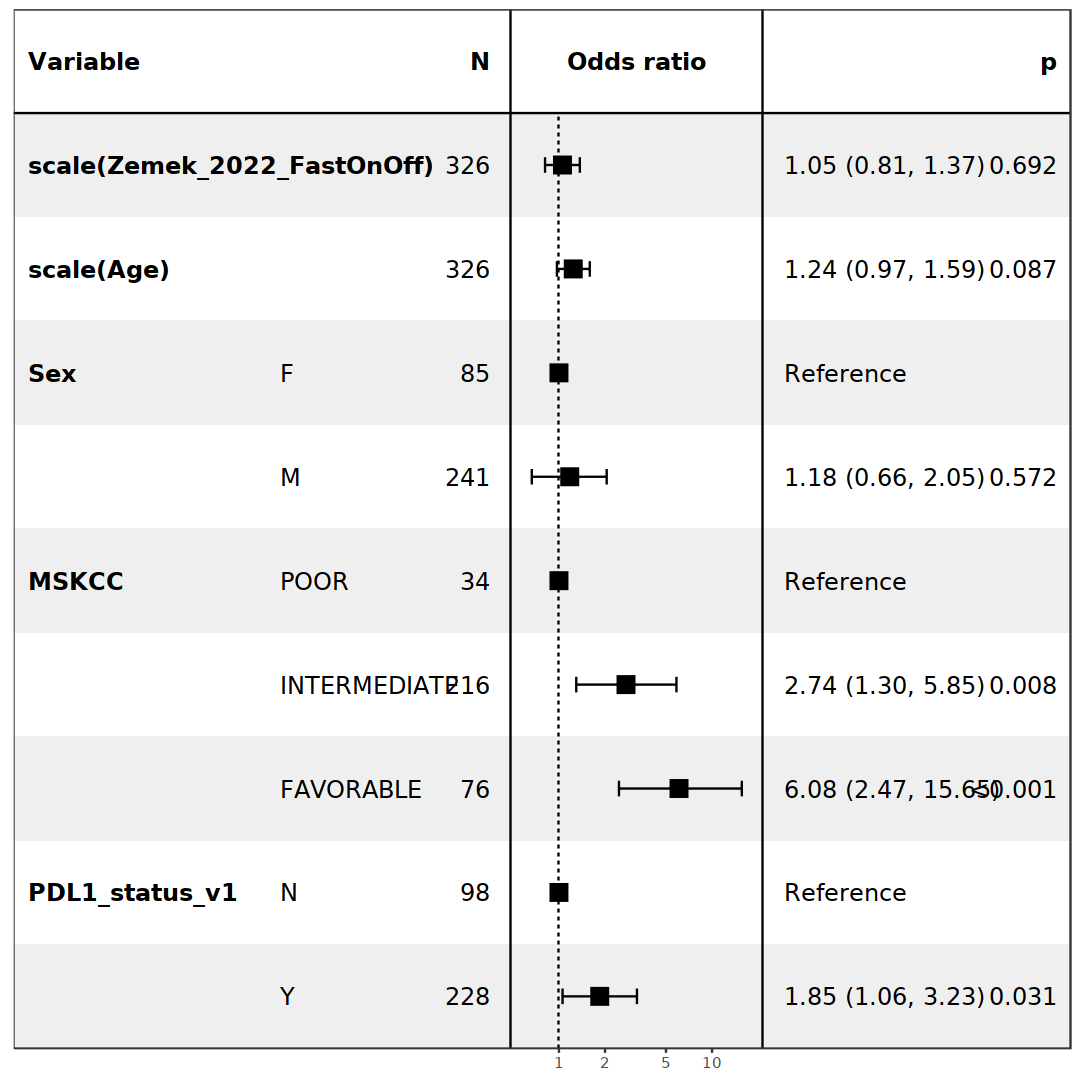

In [32]:
options(repr.plot.width=9, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(Zemek_2022_FastOnOff) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = avel_axit)
summary(mylogit)
vif(mylogit)

jav101_lr_plot = forest_model(mylogit,panels,recalculate_width = F)
jav101_lr_plot

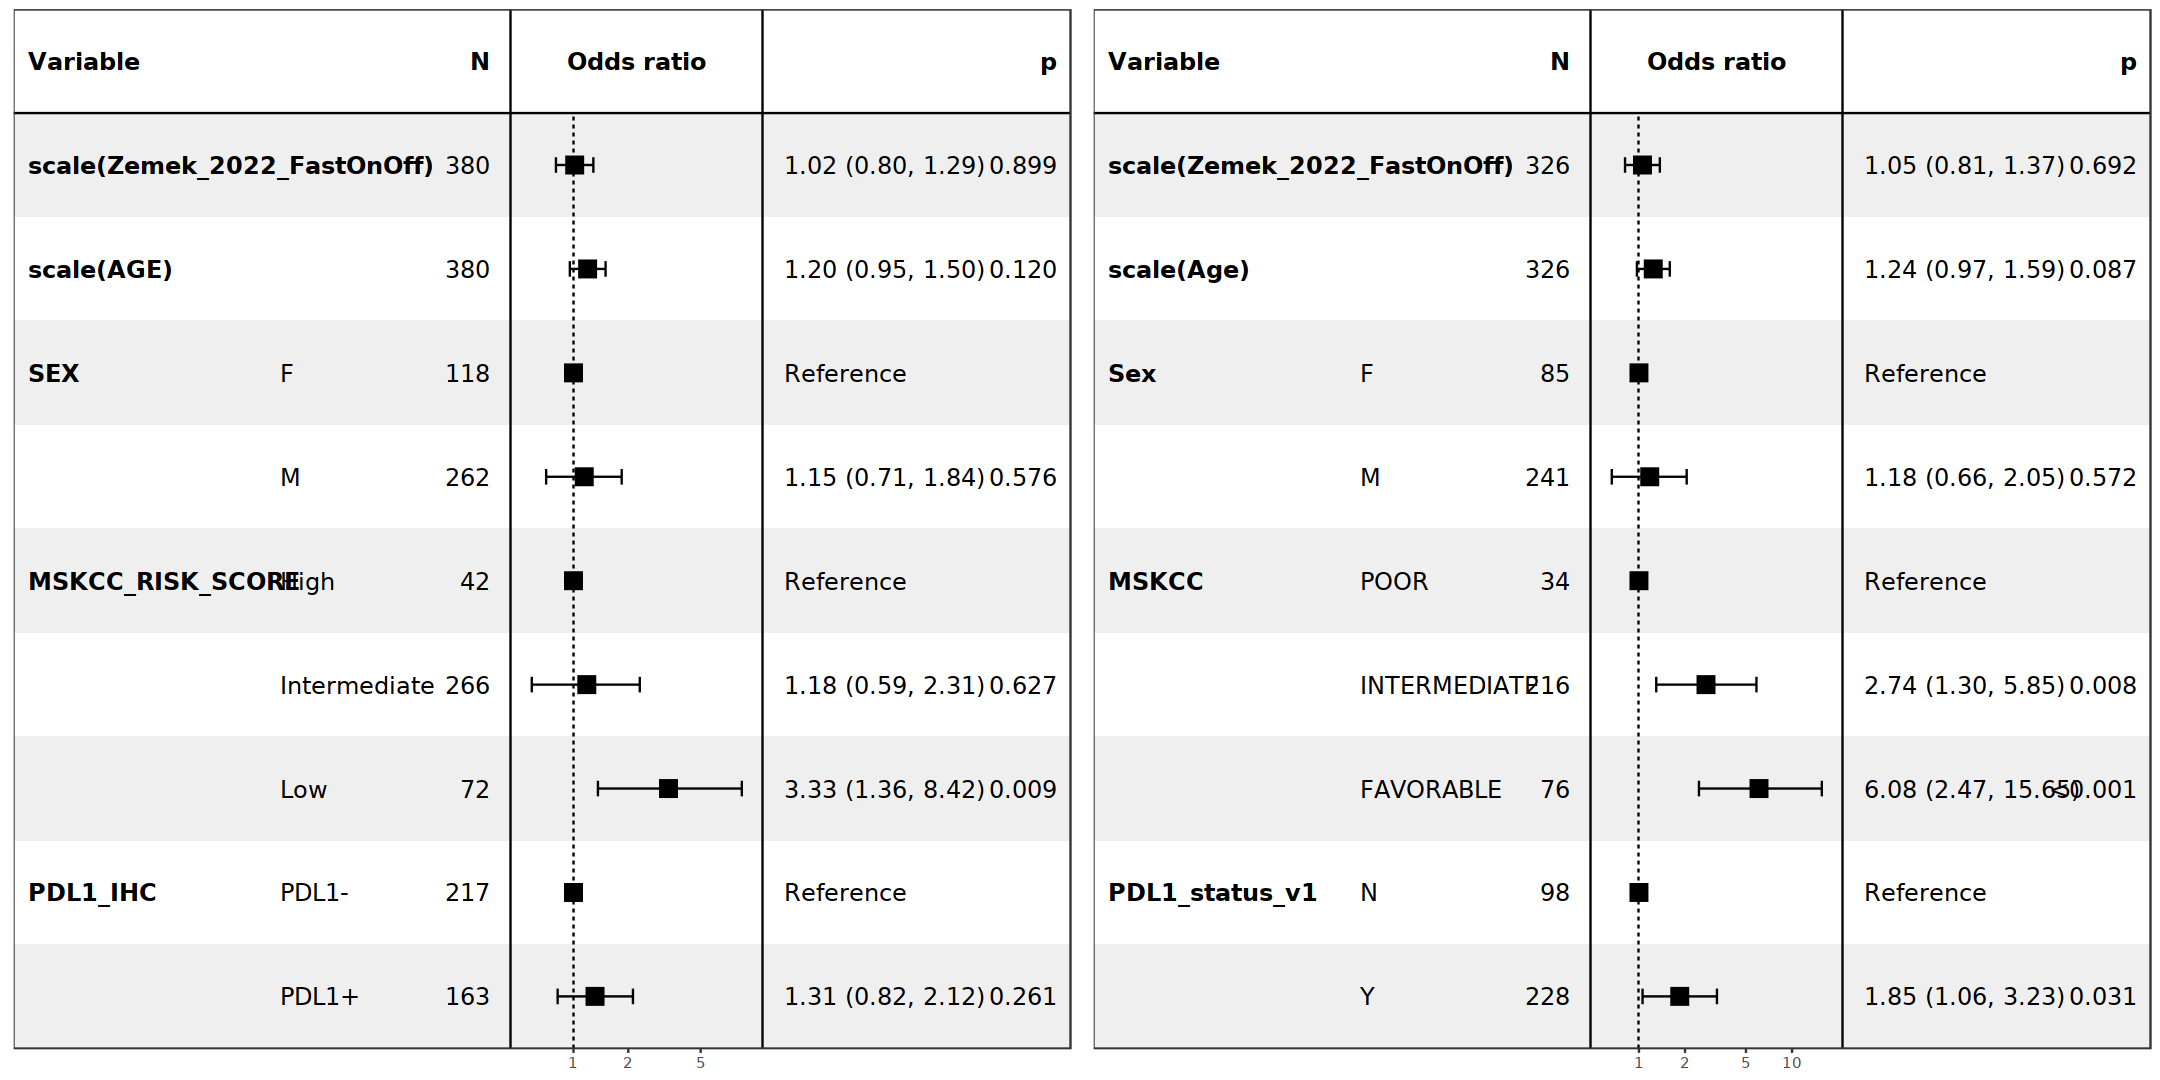

In [33]:
options(repr.plot.width=18, repr.plot.height=9)

ggarrange(imm151_lr_plot, jav101_lr_plot)

ggsave("../../Supp_Figures/Supp_Figure10_11/Supp_Figure11C_D_lr_Imm151_Jav101_Zemek_ICB_Scaled.pdf",width = 18, height = 9)